# StereoModelの学習



### ライブラリインポート

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np

#layers:様々な層を定義するためのクラス．models:モデルを定義をするためのクラス
from tensorflow.keras import layers, models
from keras.models import Model
from tensorflow.keras.layers import Input
#重みを保存するためのクラスたち
#ModelCheckpoint:モデルの保存の設定をするクラス．CSVLogger:CSVにログを残すクラス．ReduceLROnPlateau:学習率の減衰をするためのクラス．
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
#クラス分類用のクラス．
from tensorflow.keras.utils import to_categorical
#preprocess_input:入力データを最適化するクラス
from tensorflow.keras.applications.vgg16 import preprocess_input
#活性化関数
from tensorflow.keras.optimizers import SGD

#警告文のレベルを下げる
import os 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

/home/hiroto_yonekawa/anaconda3/envs/py38-tf27/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### GPU設定

In [2]:
#利用可能なGPUが存在するか確認する．
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
        print('{} memory growth: {}'.format(device, tf.config.experimental.get_memory_growth(device)))
else:
    print("Not enough GPU hardware devices available")

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.test.is_gpu_available())

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') memory growth: True
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2348691162286437341
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10722279424
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16661558559436310882
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
True


### データセット読み込み
* [tfds.load](https://www.tensorflow.org/datasets/api_docs/python/tfds/load)

In [ ]:
learning_dataset= 'sndl_size_discrim_stereo'

# 作成したデータセットの読み込み
dataset, dataset_metadata = tfds.load(learning_dataset, 
                                      with_info = True, 
                                      shuffle_files = True,
                                      as_supervised = True,
                                      )

print(dataset_metadata)

tfds.core.DatasetInfo(
    name='sndl_size_discrim_stereo',
    full_name='sndl_size_discrim_stereo/1.0.0',
    description="""
    Custom dataset with 'large' and 'small' labels. fixed 2024.01.26. 21:54
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/sndl_size_discrim_stereo',
    data_path='/home/hiroto_yonekawa/tensorflow_datasets/sndl_size_discrim_stereo/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=7.74 GiB,
    features=FeaturesDict({
        'image_L': Image(shape=(224, 224, 3), dtype=uint8),
        'image_R': Image(shape=(224, 224, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image_L', 'image_R', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=448000, num_shards=64>,
        'validation': <SplitInfo num_examples=112000, num_shards=16>,
    },
    citation="""""",
)


### データセット情報の抽出

In [ ]:
C = dataset_metadata.features['label'].num_classes          # クラス数
Ntrain = dataset_metadata.splits['train'].num_examples      # 学習データ数
Nval = dataset_metadata.splits['validation'].num_examples   # 検証データ数
Nbatch = 120                                                # バッチ数
train = dataset['train']                                    # 学習用データセット
validation = dataset['validation']                          # 検証用データセット

print(C,Ntrain, Nval)

2 448000 112000


### モデル定義

In [ ]:
latest_hdf5 = '/mnt/da6766c1-79b0-462e-8497-618f7d32c7e9/Learning_model_save_file_sndl_disparity_discrim_gabor_geometrical_size/2024_1_26/2024_1_26_sndl_disparity_discrim_gabor_epoch10.hdf5'
stereo_basemodel = tf.keras.models.load_model(latest_hdf5) #モデルを呼び出す

In [ ]:
stereo_basemodel = models.Model(inputs=stereo_basemodel.input, outputs=stereo_basemodel.layers[-2].output)  # モデル
prediction = layers.Dense(2, activation='softmax', name='prediction')(stereo_basemodel.output)              # 
stereomodel = models.Model(inputs=stereo_basemodel.input, outputs=prediction)                               # 

In [ ]:
stereomodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Leye_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Reye_input (InputLayer)        [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Leye_block1_conv1 (Conv2D)     (None, 224, 224, 64  1792        ['Leye_input[0][0]']             
                                )                                                           

In [ ]:
# trainabilityの設定を初期化
for layer in stereomodel.layers:
    layer.trainable = True
    
# 最後のconv層の直前までの層をフリーズ
for layer in stereomodel.layers[:-6]:
    layer.trainable = False

# trainableの設定を確認
for i in stereomodel.layers:
    print(i.name, i.trainable)

Leye_input False
Reye_input False
Leye_block1_conv1 False
Reye_block1_conv1 False
Leye_block1_conv2 False
Reye_block1_conv2 False
Leye_block1_pool False
Reye_block1_pool False
tf.stack False
block2_conv1_3Dconv False
tf.__operators__.getitem False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
flatten True
fc1 True
do1 True
fc2 True
do2 True
prediction True


### モデルの重みを保存する場所の指定

In [ ]:
import datetime

dt_now = datetime.datetime.now()

#実行日を自動で入力する設定
date = f'{dt_now.year}_{dt_now.month}_{dt_now.day}'
base_dir=f'/mnt/da6766c1-79b0-462e-8497-618f7d32c7e9/Learning_model_save_file_{learning_dataset}_geometrical_size/{date}'
os.makedirs(base_dir,exist_ok=True)

### モデル保存拡張子の指定

In [ ]:
hdf5_file = base_dir + f"/{date}_{learning_dataset}" + "_{epoch}.hdf5"

### モデルチェックポイントの設定

In [12]:
save_freq = 2
step_per_epoch = Ntrain // Nbatch
model_checkpoint = ModelCheckpoint(filepath=hdf5_file,
                                   save_weight_only=True,
                                   verbose=1,
                                   save_freq=int(save_freq*step_per_epoch))

### 学習によるaccuracyとlossの記録

In [13]:
csv_logger = CSVLogger(base_dir + "/{}_vgg_training.csv".format(date))

### 学習率の減衰設定

In [14]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              patience=5,factor=0.1, 
                              min_lr = 0.00001)

### 最適化関数の設定

In [15]:
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

### モデルのコンパイル

In [16]:
stereomodel.compile(optimizer=adam,
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1)])

### Dataset Generatorの設定

In [ ]:
def dataset_generator(dataset, batch_size=160, num_classes=C):
    S=256
    images_L = np.zeros((batch_size,224,224,3))     # 左目用画像
    images_R = np.zeros((batch_size,224,224,3))     # 右目用画像
    labels = np.zeros((batch_size, num_classes))    # ラベル
    seed = 0                                        # シード値 
    
    while True:
        count = 0
        for sample in tfds.as_numpy(dataset):
            image_L = sample[0]
            image_R = sample[1]
            label = sample[2]
            
            seed+=1
            
            # 画像リサイズ
            height = image_L.shape[0]
            width = image_L.shape[1]
            h_r = S / height
            w_r = S / width
            if w_r < h_r:
                re_image_L = tf.image.resize(image_L,(round(h_r*height),round(h_r*width)))
                re_image_R = tf.image.resize(image_R,(round(h_r*height),round(h_r*width)))
            else:
                re_image_L = tf.image.resize(image_L,(round(w_r*height),round(w_r*width)))
                re_image_R = tf.image.resize(image_R,(round(w_r*height),round(w_r*width)))
            
            # ピクセル値を整数型に変換（四捨五入）
            re_image_L = np.round(re_image_L).astype(np.int64)
            re_image_R = np.round(re_image_R).astype(np.int64)
            
            # ランダムクロップ（同じシードを設定して左右の画像が対応するように）
            tf.random.set_seed(seed)
            re_image_L = tf.image.random_crop(re_image_L,size=(224,224,3), seed=seed)
            tf.random.set_seed(seed)
            re_image_R = tf.image.random_crop(re_image_R,size=(224,224,3), seed=seed)
            
            # 画像の前処理
            images_L[count%batch_size] = np.expand_dims(preprocess_input(re_image_L),0)
            images_R[count%batch_size] = np.expand_dims(preprocess_input(re_image_R),0)

            # ラベルをOne-Hotエンコーディング
            labels[count%batch_size] = np.expand_dims(to_categorical(label, num_classes=num_classes),0)

            count += 1
            
            # バッチサイズごとにデータをyield（ミニバッチ学習のため）
            if(count%batch_size == 0):
                yield [images_L, images_R], labels

### 学習前のモデルの判別精度

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE # データパイプラインのパフォーマンス向上のための最適なスレッド数を自動設定
S=256                       # 画像のリサイズ時に使用する基準サイズ

# ラベルをone-hotエンコーディングに変換する関数
def to_categorical(y, num_classes):
    y = tf.cast(y, tf.int32)
    categorical = tf.one_hot(y, num_classes, dtype='float32')
    return categorical

# 入力画像の前処理を行う関数
def preprocess_input(image_L, image_R, label):
    height = 224
    width = 224
    h_r = S / height
    w_r = S / width

    # 画像のリサイズ
    if w_r < h_r:
        re_image_L = tf.image.resize(image_L,(round(h_r*height),round(h_r*width)))
        re_image_R = tf.image.resize(image_R,(round(h_r*height),round(h_r*width)))
    else:
        re_image_L = tf.image.resize(image_L,(round(w_r*height),round(w_r*width)))
        re_image_R = tf.image.resize(image_R,(round(w_r*height),round(w_r*width)))
    
    # 画素値を四捨五入して整数型に変換
    re_image_L = tf.cast(tf.math.round(re_image_L), tf.int64)
    re_image_R = tf.cast(tf.math.round(re_image_R), tf.int64)
    
    # ランダムクロップ（同じseedを設定し、左右の画像が対応するようにする）
    seed=0
    tf.random.set_seed(seed)
    re_image_L = tf.image.random_crop(re_image_L,size=(224,224,3), seed=seed)
    tf.random.set_seed(seed)
    re_image_R = tf.image.random_crop(re_image_R,size=(224,224,3), seed=seed)

    # ラベルをone-hotエンコーディングに変換
    label = to_categorical(label, num_classes=2)
    
    return (re_image_L, re_image_R), label

# 学習用データの評価
train_acc, train_loss = stereomodel.evaluate(train.map(preprocess_input, num_parallel_calls=AUTOTUNE).batch(Nbatch).prefetch(AUTOTUNE), verbose=1)
print(train_acc, train_loss)
# 検証用データの評価
validation_acc, validation_loss = stereomodel.evaluate(validation.map(preprocess_input, num_parallel_calls=AUTOTUNE).batch(Nbatch).prefetch(AUTOTUNE), verbose=1)
print(validation_acc, validation_loss)

3734/3734 [==============================] - 1989s 528ms/step - loss: 1.6822 - top_k_categorical_accuracy: 0.5050
1.6821544170379639 0.504986584186554
934/934 [==============================] - 492s 527ms/step - loss: 1.6804 - top_k_categorical_accuracy: 0.5042
1.680442214012146 0.5042232275009155


### 学習

In [18]:
# Start_Epoch = 2
history = stereomodel.fit(
        dataset_generator(train,Nbatch),
        epochs = 5,
        # initial_epoch= Start_Epoch,
        steps_per_epoch = step_per_epoch,
        batch_size = Nbatch,
        validation_data = dataset_generator(validation,batch_size=Nbatch),
        validation_steps = Nval // Nbatch, 
        verbose = 1,
        callbacks = [reduce_lr,model_checkpoint, csv_logger]
)

Epoch 1/15
3733/3733 [==============================] - 5889s 2s/step - loss: 0.6126 - top_k_categorical_accuracy: 0.9851 - val_loss: 0.5510 - val_top_k_categorical_accuracy: 0.9949 - lr: 1.0000e-04
Epoch 2/15
3732/3733 [============================>.] - ETA: 1s - loss: 0.5461 - top_k_categorical_accuracy: 0.9924
Epoch 00002: saving model to /mnt/da6766c1-79b0-462e-8497-618f7d32c7e9/Learning_model_save_file_sndl_size_discrim_stereo_geometrical_size/2024_1_26/2024_1_26_sndl_size_discrim_stereo_2.hdf5
3733/3733 [==============================] - 5845s 2s/step - loss: 0.5461 - top_k_categorical_accuracy: 0.9924 - val_loss: 0.5310 - val_top_k_categorical_accuracy: 0.9964 - lr: 1.0000e-04
Epoch 3/15
  73/3733 [..............................] - ETA: 1:20:36 - loss: 0.5396 - top_k_categorical_accuracy: 0.9927

KeyboardInterrupt: 

### モデルの保存

In [ ]:
# stereomodel.save_weights(hdf5_file)
# stereomodel.save(base_dir + '/{}_{}_epoch10.hdf5'.format(date,learning_dataset))
# print(base_dir + '/{}_{}_epoch10.hdf5'.format(date,learning_dataset))

/mnt/da6766c1-79b0-462e-8497-618f7d32c7e9/Learning_model_save_file_sndl_size_discrim_stereo_geometrical_size/2024_1_21/2024_1_21_sndl_size_discrim_stereo_epoch10.hdf5


### 学習結果のプロット

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 学習結果が保存されたcsvファイルを読み込む
csvpath = '/mnt/da6766c1-79b0-462e-8497-618f7d32c7e9/Learning_model_save_file_sndl_size_discrim_stereo_geometrical_size/2024_1_26/2024_1_26_vgg_training.csv'
log_file = pd.read_csv(csvpath)
log_file[-5:]

,epoch,loss,lr,top_k_categorical_accuracy,val_loss,val_top_k_categorical_accuracy
0,0,1.682154,0.0001,0.504987,1.680442,0.504223
1,1,0.612584,0.0001,0.985059,0.551044,0.994945
2,2,0.546051,0.0001,0.992372,0.531019,0.996418


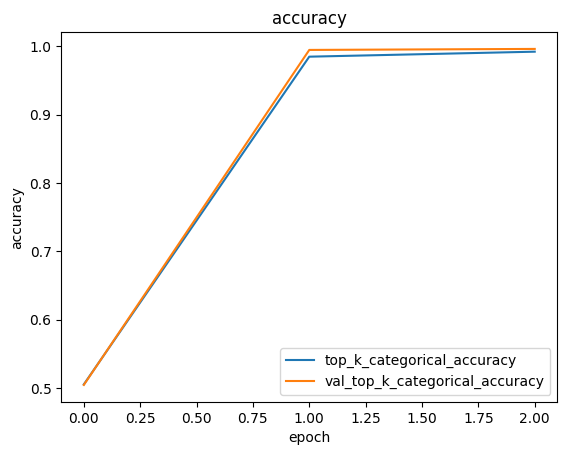

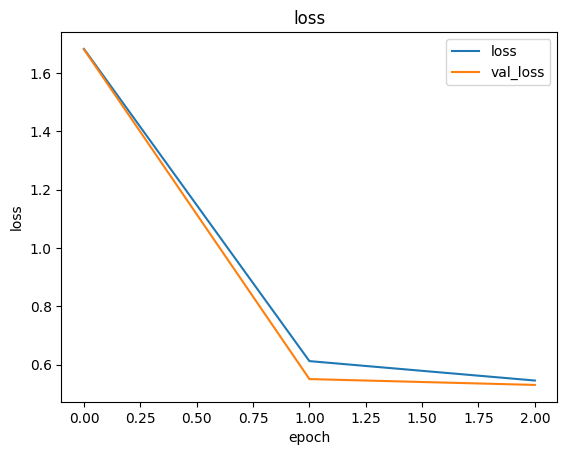

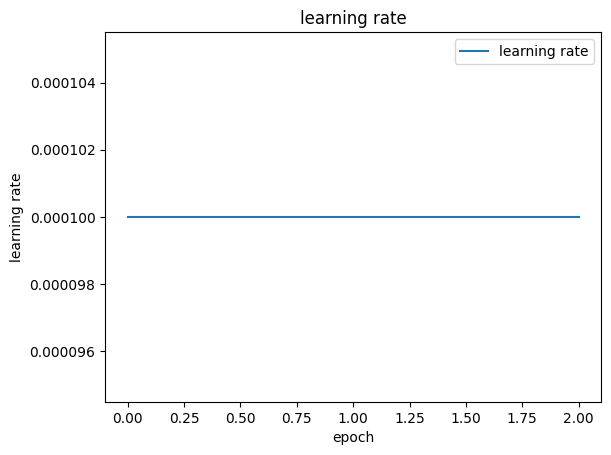

In [ ]:
plt.figure()
plt.plot(log_file['epoch'], log_file['top_k_categorical_accuracy'], label='top_k_categorical_accuracy')
plt.plot(log_file['epoch'], log_file['val_top_k_categorical_accuracy'], label='val_top_k_categorical_accuracy')
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


plt.figure()
plt.plot(log_file['epoch'], log_file['loss'], label='loss')
plt.plot(log_file['epoch'], log_file['val_loss'], label='val_loss')
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()


plt.figure()
plt.plot(log_file['epoch'], log_file['lr'], label='learning rate')
plt.title('learning rate')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.legend()


# 擬似心理物理実験を適用

### ライブラリインポート

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from PIL import Image
from scipy.optimize import curve_fit
from scipy.stats import norm
import re

from tensorflow.keras.applications.vgg16 import preprocess_input

import os

### 実験用画像の読み込み

In [ ]:
df_near = pd.read_csv('/home/hiroto_yonekawa/database/psychophysical_exp_stereo_size/label_near.csv')
df_center = pd.read_csv('/home/hiroto_yonekawa/database/psychophysical_exp_stereo_size/label_center.csv')
df_far = pd.read_csv('/home/hiroto_yonekawa/database/psychophysical_exp_stereo_size/label_far.csv')

rownum, colnum = df_center.shape
colnum = colnum//2
print(colnum, rownum)

9 100


### モデル読み込み

In [ ]:
model_path = '/mnt/da6766c1-79b0-462e-8497-618f7d32c7e9/Learning_model_save_file_sndl_size_discrim_stereo_geometrical_size/2024_1_26/2024_1_26_sndl_size_discrim_stereo_2.hdf5'
stereomodel = tf.keras.models.load_model(model_path)

2024-02-14 13:58:30.694072: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-14 13:58:30.697811: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-14 13:58:30.697902: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-02-14 13:58:30.698168: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

### 実験用画像の確認

In [ ]:
# 例として遠距離条件の画像を1枚取得
ifig=59
left_path = df_far['6_path_leye'][ifig]
right_path = df_far['6_path_reye'][ifig]
print(left_path)
print(right_path)

/home/hiroto_yonekawa/database/psychophysical_exp_stereo_size/left/large/leye_large_LTest_far_02459.jpg
/home/hiroto_yonekawa/database/psychophysical_exp_stereo_size/right/large/reye_large_LTest_far_02459.jpg


(1, 224, 224, 3)


2024-02-14 13:58:37.981311: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2024-02-14 13:58:38.976770: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


[[0.63555413 0.3644458 ]]
leye_large_LTest_far_02459.jpg
large
L


2024-02-14 13:58:39.438205: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


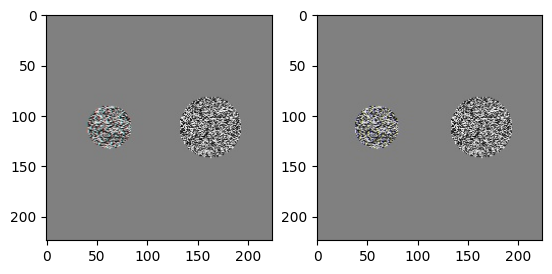

In [ ]:
label = {0:'large', 1:'small'}

image_L = np.array(Image.open(left_path))
image_R = np.array(Image.open(right_path))

plt.subplot(1,2,1)
plt.imshow(image_L)
plt.subplot(1,2,2)
plt.imshow(image_R)

image_L = np.expand_dims(preprocess_input(image_L),0)
image_R = np.expand_dims(preprocess_input(image_R),0)

print(np.shape(image_L))

# 予測の実行
ans = stereomodel.predict([image_L, image_R])   # 予測
print(ans)                                      # 予測結果(確率値)
ans = label[np.argmax(ans)]                     # 予測結果を'small' または 'large'の表記に変換

# ファイル名から不要な部分を削除し、テストディスクの位置情報を抽出
name = os.path.split(left_path)[1]
print(name)
name=re.sub('Test_.*', '', name)
name=re.sub('.*_', '', name)

print(ans)
print(name)

### 擬似心理物理実験で予測を行う関数

In [ ]:
def prediction(trained_model, leye_path, reye_path, label):
    # 画像読み込み、前処理
    img_L = np.array(Image.open(leye_path))
    img_R = np.array(Image.open(reye_path))
    img_L = np.expand_dims(preprocess_input(img_L),0)
    img_R = np.expand_dims(preprocess_input(img_R),0)

    # 予測実行
    ans = trained_model.predict([img_L, img_R])     # 予測
    ans = label[np.argmax(ans)]                     # 予測結果を'small' または 'large'の表記に変換

    
    # ファイル名から不要な部分を削除し、テストディスクの位置情報を抽出
    testPos = os.path.split(leye_path)[1]           # ファイル名の取得
    testPos = re.sub('Test_.*', '', testPos)        # Test diskが左右どちらにあるか (L or R)
    testPos = re.sub('.*_', '', testPos)
    
    return ans, testPos

### 実験適用

In [ ]:
# モデルに画像を投入し予測
label = {0:'large', 1:'small'}
selected_cnt_near = np.zeros(9)     # 近い条件のテストディスク選択回数をカウント
selected_cnt_center = np.zeros(9)   # 基準距離の条件のテストディスク選択回数をカウント
selected_cnt_far = np.zeros(9)      # 遠い条件のテストディスク選択回数をカウント

for ii in range(colnum):
    for jj in range(rownum):
        leye_path_near = df_near[f'{ii}_path_leye'][jj]                 # ファイル取得
        reye_path_near = df_near[f'{ii}_path_reye'][jj]                 # ファイル取得
        
        leye_path_center = df_center[f'{ii}_path_leye'][jj]             # ファイル取得
        reye_path_center = df_center[f'{ii}_path_reye'][jj]             # ファイル取得
        
        leye_path_far = df_far[f'{ii}_path_leye'][jj]                   # ファイル取得
        reye_path_far = df_far[f'{ii}_path_reye'][jj]                   # ファイル取得
        
        # 近い条件の画像の予測とテストディスクの位置取得
        ans_near, testPos_near = prediction(stereomodel, leye_path_near, reye_path_near, label)
        if ((ans_near=='large')and(testPos_near=='R')) or ((ans_near=='small')and(testPos_near=='L')):  # test diskが選択された
            selected_cnt_near[ii] +=1
        elif ((ans_near=='large')and(testPos_near=='L')) or ((ans_near=='small')and(testPos_near=='R')):# test diskが選択されなかった
            selected_cnt_near[ii] +=0
        else:
            print('error in near')
            break
        
        # 基準距離の条件の画像の予測とテストディスクの位置取得
        ans_center, testPos_center = prediction(stereomodel, leye_path_center, reye_path_center, label)
        if ((ans_center=='large')and(testPos_center=='R')) or ((ans_center=='small')and(testPos_center=='L')): # test diskが選択された
            selected_cnt_center[ii] +=1
        elif ((ans_center=='large')and(testPos_center=='L')) or ((ans_center=='small')and(testPos_center=='R')): # test diskが選択されなかった
            selected_cnt_center[ii] +=0
        else:
            print('error in center')
            break
        
        # 遠い条件の画像の予測とテストディスクの位置取得
        ans_far, testPos_far = prediction(stereomodel, leye_path_far, reye_path_far, label)
        if ((ans_far=='large')and(testPos_far=='R')) or ((ans_far=='small')and(testPos_far=='L')): # test diskが選択された
            selected_cnt_far[ii] +=1
        elif ((ans_far=='large')and(testPos_far=='L')) or ((ans_far=='small')and(testPos_far=='R')): # test diskが選択されなかった
            selected_cnt_far[ii] +=0
        else:
            print('error in far')
            break

# 各距離条件での選択率を計算し、出力（逆順）
print((selected_cnt_near/rownum)[::-1])
print((selected_cnt_center/rownum)[::-1])
print((selected_cnt_far/rownum)[::-1])

[0.  0.  0.  0.  0.  0.  0.5 1.  1. ]
[0.  0.  0.  0.  0.5 1.  1.  1.  1. ]
[0.   0.   0.17 1.   1.   1.   1.   1.   1.  ]


### 予測結果から刺激パラメータごとに確率値に変換

Text(0, 0.5, 'proportion of \n"Test disk" choice')

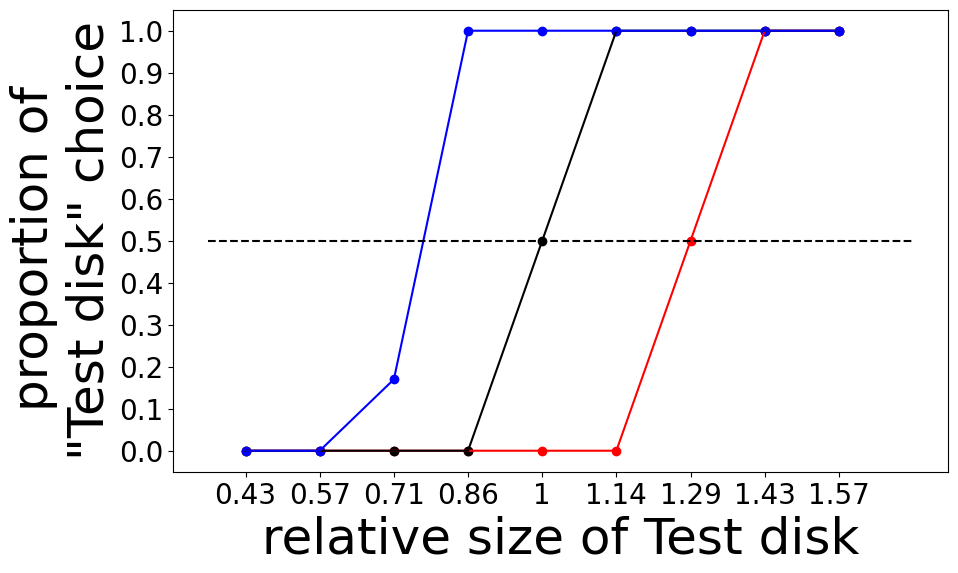

In [ ]:
# 確率値に変換
selected_P_near = selected_cnt_near[::-1]/rownum
selected_P_center = selected_cnt_center[::-1]/rownum
selected_P_far = selected_cnt_far[::-1]/rownum

TestDisk_radius_arr = [1.57, 1.43, 1.29, 1.14, 1, 0.86, 0.71, 0.57, 0.43]    # Test diskの半径(Reference diskに対する相対値)
TestDisk_radius_arr = TestDisk_radius_arr[::-1]

# 結果のプロット
plt.figure(figsize=(10,6))
plt.scatter(np.arange(len(TestDisk_radius_arr)), selected_P_near, c='red')
plt.plot(np.arange(len(TestDisk_radius_arr)), selected_P_near, color='red')
plt.scatter(np.arange(len(TestDisk_radius_arr)), selected_P_center, c='black')
plt.plot(np.arange(len(TestDisk_radius_arr)), selected_P_center, color='black')
plt.scatter(np.arange(len(TestDisk_radius_arr)), selected_P_far, c='blue')
plt.plot(np.arange(len(TestDisk_radius_arr)), selected_P_far, color='blue')

plt.plot([-0.5, 9], [0.5, 0.5], color='black', linestyle='--')
plt.xticks(np.arange(len(TestDisk_radius_arr)), TestDisk_radius_arr, fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=20)
plt.xlabel('relative size of Test disk', fontsize=36)
plt.ylabel('proportion of \n"Test disk" choice', fontsize=36)

# plt.savefig('./size_discrimination_stereo.jpg')

### ガウス関数によるフィッティング

In [ ]:
# ガウスフィッティング
def gauss(x, mu, sigma):
    y = norm.cdf(x, loc=mu, scale=sigma)
    return y

# 決定係数算出
def R_square(y, f, y_bar):
    y_bar = np.mean(y)
    SSres = np.sum((y - f)**2)
    SStot = np.sum((y - y_bar)**2)
    R2 = 1-(SSres/SStot)
    return R2

In [ ]:
# x軸のデータを作成
xx = np.linspace(np.min(TestDisk_radius_arr), np.max(TestDisk_radius_arr), 100)

# 初期値の設定
fitting_N = 10                               # フィッティングの試行回数
mu = np.random.uniform(0.4, 1.7, fitting_N)  # μの初期値をランダムに設定
sigma = np.random.uniform(0, 4, fitting_N)   # σの初期値をランダムに設定

goodnessfit_best = -9999                     # 最良の適合度を記録する変数
param_best = None                            # 最良のパラメータを記録する変数
fit_ii = 0                                   # フィッティングの試行回数カウンタ

while fit_ii < fitting_N:
    # 初期パラメータを設定
    init_param_near = [mu[fit_ii], sigma[fit_ii]]
    init_param_center = [mu[fit_ii], sigma[fit_ii]]
    init_param_far = [mu[fit_ii], sigma[fit_ii]]

    # ガウス関数を用いてカーブフィッティングを実行
    fit_param_near, cov_near = curve_fit(gauss, TestDisk_radius_arr, selected_P_near, p0=init_param_near, maxfev=120000)
    fit_param_center, cov_center = curve_fit(gauss, TestDisk_radius_arr, selected_P_center, p0=init_param_center, maxfev=120000)
    fit_param_far, cov_far = curve_fit(gauss, TestDisk_radius_arr, selected_P_far, p0=init_param_far, maxfev=120000)

    # フィッティング結果を取得
    y_fit_near = gauss(TestDisk_radius_arr, fit_param_near[0], fit_param_near[1])
    y_fit_center = gauss(TestDisk_radius_arr, fit_param_center[0], fit_param_center[1])
    y_fit_far = gauss(TestDisk_radius_arr, fit_param_far[0], fit_param_far[1])

    # 適合度（R^2）を計算
    avg_y_near = np.mean(y_fit_near)
    avg_y_center = np.mean(y_fit_center)
    avg_y_far = np.mean(y_fit_far)

    goodnessfit_near = R_square(selected_P_near, y_fit_near, avg_y_near)
    goodnessfit_center = R_square(selected_P_center, y_fit_center, avg_y_center)
    goodnessfit_far = R_square(selected_P_far, y_fit_far, avg_y_far)

    # 最良の適合度とパラメータを記録
    if goodnessfit_near > goodnessfit_best:
        goodnessfit_best = goodnessfit_near
        param_best_near = fit_param_near
        PSE_near = fit_param_near[0]            # Point of Subjective Equality (主観的等価点)
    if goodnessfit_center > goodnessfit_best:
        goodnessfit_best = goodnessfit_center
        param_best_center = fit_param_center
        PSE_center = fit_param_center[0]
    if goodnessfit_far > goodnessfit_best:
        goodnessfit_best = goodnessfit_far
        param_best_far = fit_param_far
        PSE_far = fit_param_far[0]
    
    fit_ii += 1  # 試行回数をインクリメント

# 最良のフィット結果を計算
y_fit_0 = gauss(xx, param_best_near[0], param_best_near[1])
y_fit_1 = gauss(xx, param_best_center[0], param_best_center[1])
y_fit_2 = gauss(xx, param_best_far[0], param_best_far[1])

/home/hiroto_yonekawa/anaconda3/envs/py38-tf27/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


### 解析結果のプロット

In [ ]:
import datetime

dt_now = datetime.datetime.now()
date = '{}_{}_{}'.format(dt_now.year,dt_now.month,dt_now.day)

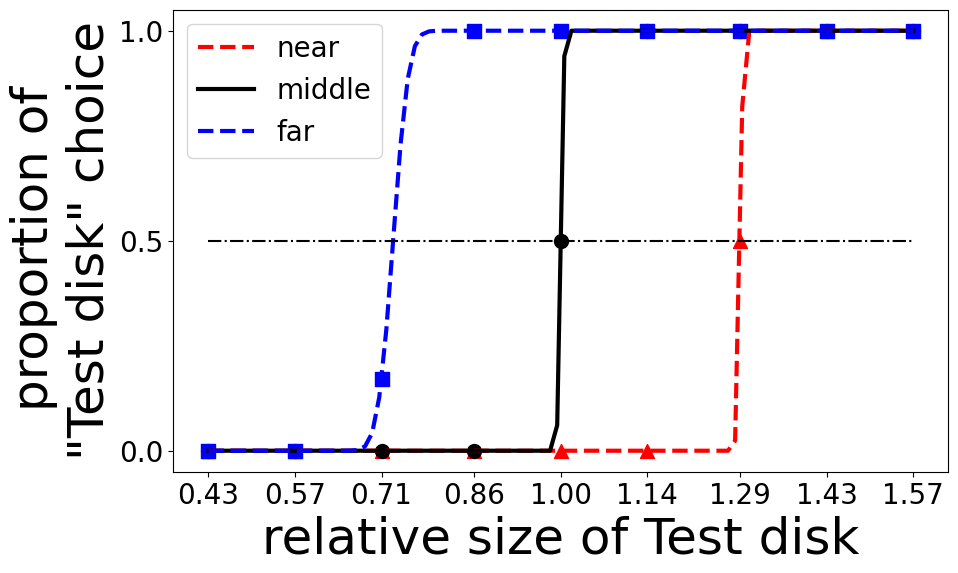

In [16]:
plt.figure(figsize=(10,6))
plt.scatter(TestDisk_radius_arr, selected_P_near, color='red', marker='^', s=100)
plt.plot(xx, y_fit_0, color='red', linestyle='dashed',linewidth=3, label='near')
plt.scatter(TestDisk_radius_arr, selected_P_center, color='black', s=100)
plt.plot(xx, y_fit_1, color='black',linewidth=3, label='middle')
plt.scatter(TestDisk_radius_arr, selected_P_far, color='blue', marker=',', s=100)
plt.plot(xx, y_fit_2, color='blue', linestyle='dashed',linewidth=3, label='far')

plt.plot([np.min(TestDisk_radius_arr), np.max(TestDisk_radius_arr)], [0.5, 0.5], color='black', linestyle='dashdot')

plt.yticks([0, 0.5, 1.0], fontsize=20)
plt.xticks(TestDisk_radius_arr, fontsize=20)
plt.xlabel('relative size of Test disk', fontsize=36)
plt.ylabel('proportion of \n"Test disk" choice', fontsize=36)
# plt.savefig(f'./size_discrimination_stereo_{date}_psychometric_curve.jpg')
plt.legend(fontsize=20)

[1.29, 1.0, 0.7287731094079047]


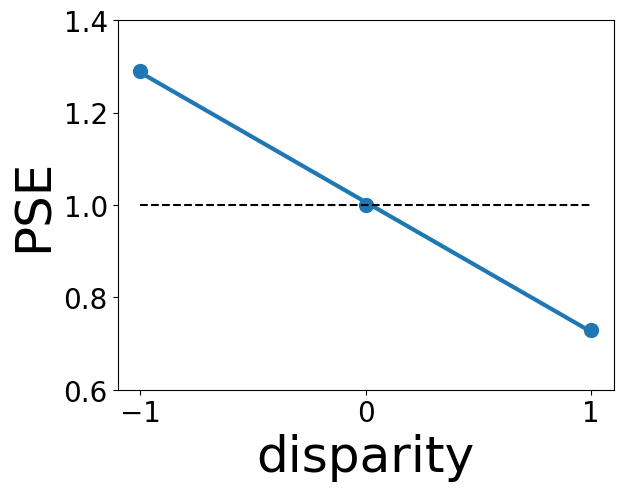

In [ ]:
# 線形回帰直線のフィッティング
def linear(xx, a, b):
    yy = a*xx + b
    return yy

# 距離ごとのPSE
PSE = [PSE_near, PSE_center, PSE_far]
print(PSE)

# フィッティングを実行
init_param = [-1, 1]
fit_param, cov = curve_fit(linear, np.arange(-1.0, 1.1), PSE, p0=init_param)
y_fit = linear(np.arange(-1.0, 1.1), fit_param[0], fit_param[1])


plt.plot(np.arange(-1.0, 1.1), y_fit,linewidth=3)
plt.scatter(np.arange(-1.0, 1.1), PSE, s=100)
plt.plot(np.arange(-1.0, 1.1), [1.0,1.0,1.0], color='black', linestyle='--')
plt.yticks([0.6, 0.8, 1.0, 1.2, 1.4], fontsize=20)
plt.xticks(np.arange(-1.0, 1.1), fontsize=20)
plt.xlabel('disparity', fontsize=36)
plt.ylabel('PSE', fontsize=36)
plt.savefig(f'./size_discrimination_stereo_{date}_PSE.jpg')

### 算出した選択確率、PSEをcsvに保存

In [53]:
selected_P_csv = pd.DataFrame(data=dict(near=selected_P_near, center=selected_P_center, far=selected_P_far))
selected_P_csv.head()
selected_P_csv.to_csv(f'./selected_P_{date}.csv')

In [ ]:
PSE_csv = pd.DataFrame(data=dict(PSE=PSE))